In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# パッケージのインストール&インポート
!pip install rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio

import json
import os
import glob

import time
from datetime import datetime
from dateutil.parser import parse

from PIL import Image, ImageDraw, ImageFont

In [4]:
!pip install folium

import folium

関心域のポリゴン作成およびその位置情報を取得するWebアプリを作成しました．以下のサイトより，関心粋の選択（左の作成チールより四角を選択），ポリゴンを作成。その後”Show feature”をクリックしポリゴン情報を右枠に表示させ、Copyを押して情報をコピーする。

In [5]:
#関心領域のポリゴン情報の取得．
from IPython.display import HTML
HTML(r'<iframe width="1000" height="580" src="https://gispolygon.herokuapp.com/" frameborder="0"></iframe>')

ポリゴン情報をコピーし，以下のAの右辺にペーストする．

In [6]:
A  = {"type":"FeatureCollection","features":[{"properties":{"note":"","distance":"210025.76 m","drawtype":"rectangle","area":"520197.34 ha"},"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-122.60860204696657,44.80966973731369],[-122.60860204696657,45.400920907537866],[-121.60266637802125,45.400920907537866],[-121.60266637802125,44.80966973731369],[-122.60860204696657,44.80966973731369]]]}}]}

In [7]:
#今後使用する任意のファイル名をセットする． 例えば，地域の名前など．
object_name = 'Portland'

In [8]:
with open(str(object_name) +'_2.geojson', 'w') as f:
    json.dump(A, f)

In [9]:
json_file = open(str(object_name) +'_2.geojson')
json_object = json.load(json_file)

In [10]:
#jsonから関心域の緯度・経度情報のみを抽出する．

AREA = json_object["features"][0]["geometry"]['coordinates'][0]

In [11]:
import pandas as pd

area = pd.DataFrame(AREA,
                  columns=['longtitude', 'latitude'])

In [12]:
area_d =[[area['longtitude'].min(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].max()]]

In [13]:
AREA = area_d
AREA

[[-122.60860204696657, 45.400920907537866],
 [-121.60266637802125, 45.400920907537866],
 [-121.60266637802125, 44.80966973731369],
 [-122.60860204696657, 44.80966973731369],
 [-122.60860204696657, 45.400920907537866]]

関心域の確認


In [14]:
m = folium.Map([(AREA[0][1]+AREA[len(AREA)-2][1])/2,(AREA[0][0]+AREA[len(AREA)-3][0])/2], zoom_start=9)

folium.GeoJson(str(object_name) +'_2.geojson').add_to(m)
m

In [15]:
region=ee.Geometry.Polygon(AREA)

In [16]:
region['coordinates'][0]

[[-122.60860204696657, 45.400920907537866],
 [-121.60266637802125, 45.400920907537866],
 [-121.60266637802125, 44.80966973731369],
 [-122.60860204696657, 44.80966973731369],
 [-122.60860204696657, 45.400920907537866]]

Sentinel-2 MSI: MultiSpectral Instrument, Level-1C 画像　

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2


2015-06-23T00:00:00 - 2020-08-13T00:00:00

SPACECRAFT_NAME	STRING	
Sentinel-2 spacecraft name: Sentinel-2A, Sentinel-2B

CLOUDY_PIXEL_PERCENTAGE	DOUBLE	
Granule-specific cloudy pixel percentage taken from the original metadata


In [17]:
# 期間を指定
from_date='2020-09-08'
to_date='2020-09-10'

# 保存するフォルダ名
dir_name_s2 = 'GEE_Sentinel2_' + object_name

In [18]:
def ImageExport(image,description,folder,region,scale):
    task = ee.batch.Export.image.toDrive(image=image,description=description,folder=folder,region=region,scale=scale)
    task.start()

Sentinel2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(region).filterDate(parse(from_date),parse(to_date)).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 80).select(['B12','B11','B8A'])

imageList_s2 = Sentinel2.toList(300) 

In [ ]:
for i in range(imageList_s2.size().getInfo()):
    image = ee.Image(imageList_s2.get(i))
    ImageExport(image.reproject(crs='EPSG:4326',scale=10),image.get('system:index').getInfo(),dir_name_s2,region['coordinates'][0],10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


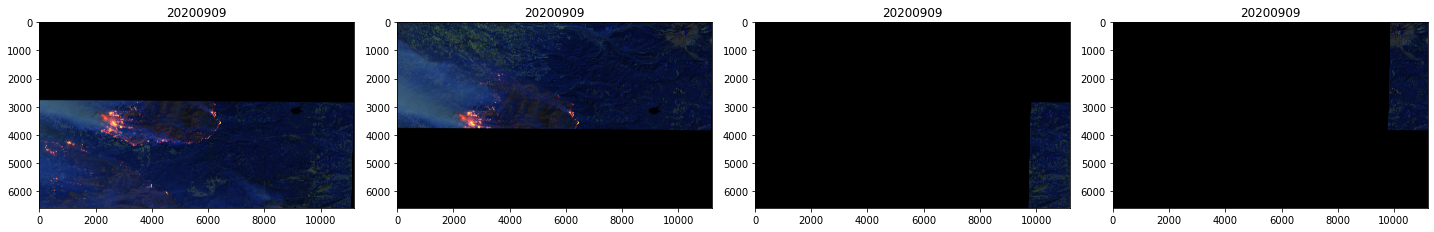

In [ ]:
# 時系列で可視化
s2_path = '/content/drive/My Drive/' + dir_name_s2 + '/'
files =os.listdir(s2_path)
files.sort()

plt.figure(figsize=(25, 25))
j=0

v = len(files)//5 +1 
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s2_path + files[i]) as src:
      arr = src.read()
  j+=1# 画像のプロット位置をシフトさせ配置
  plt.subplot(v,5,j)
  arrayImg = np.asarray(arr).transpose(1,2,0).astype(np.float16)/10000
  plt.imshow(arrayImg)
  plt.title(files[i][0:8])# ファイル名から日付を取得
  plt.tight_layout()

In [19]:
# 画像の確認
s2_path = '/content/drive/My Drive/' + dir_name_s2 + '/'
files =os.listdir(s2_path)
files.sort()

# データの読み込み
n = 0

with rasterio.open(s2_path + files[n]) as src:
    arr = src.read()

print(files[n][0:8])
# 可視化
arrayImg0 = np.asarray(arr).transpose(1,2,0).astype(np.float16)/10000
#plt.imshow(arrayImg0)

20200909


In [20]:
# 画像の確認
s2_path = '/content/drive/My Drive/' + dir_name_s2 + '/'
files =os.listdir(s2_path)
files.sort()

# データの読み込み
n = 1

with rasterio.open(s2_path + files[n]) as src:
    arr = src.read()

print(files[n][0:8])
# 可視化
arrayImg1 = np.asarray(arr).transpose(1,2,0).astype(np.float16)/10000
#plt.imshow(arrayImg1)

20200909


In [21]:
image = np.empty(arrayImg1.shape)

In [26]:
image.shape

(6596, 11199, 3)

In [22]:
for i in range(len(arrayImg1)):
  if  np.any(arrayImg1[i, :, :] > arrayImg0[i, :, :]):
   image[i, :, :] =arrayImg1[i, :, :]
  else:
   image[i, :, :] = arrayImg0[i, :, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


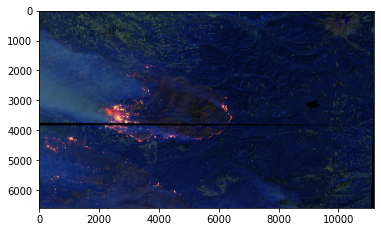

In [23]:
plt.imshow(image)

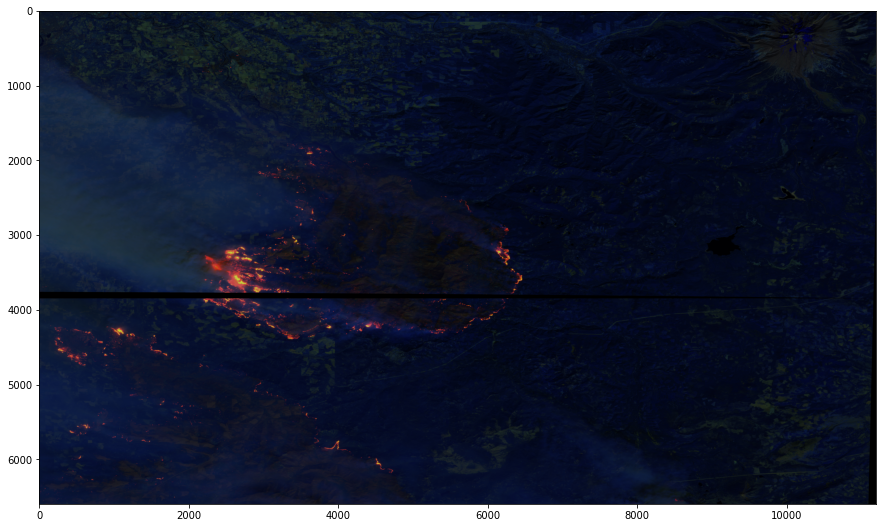

In [28]:
import cv2

new_image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')


im_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
cv2.imwrite(str(object_name) +'.jpg', im_rgb )

img = Image.open(str(object_name) +'.jpg')

plt.figure(figsize=(15, 20))

plt.imshow(img)
plt.show()

RGB合成画像に取得日やクレジットを載せる．

In [29]:
#フォントファイルのダウンロードと設定

!wget https://osdn.net/dl/mplus-fonts/mplus-TESTFLIGHT-063a.tar.xz

!xz -dc mplus-TESTFLIGHT-*.tar.xz | tar xf -

fontfile = "./mplus-TESTFLIGHT-063a/mplus-1c-bold.ttf"

--2020-10-02 09:28:32--  https://osdn.net/dl/mplus-fonts/mplus-TESTFLIGHT-063a.tar.xz
Resolving osdn.net (osdn.net)... 202.221.179.17
Connecting to osdn.net (osdn.net)|202.221.179.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://osdn.net/projects/mplus-fonts/downloads/62344/mplus-TESTFLIGHT-063a.tar.xz/ [following]
--2020-10-02 09:28:33--  https://osdn.net/projects/mplus-fonts/downloads/62344/mplus-TESTFLIGHT-063a.tar.xz/
Reusing existing connection to osdn.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://osdn.net/frs/redir.php?m=gigenet&f=mplus-fonts%2F62344%2Fmplus-TESTFLIGHT-063a.tar.xz [following]
--2020-10-02 09:28:33--  https://osdn.net/frs/redir.php?m=gigenet&f=mplus-fonts%2F62344%2Fmplus-TESTFLIGHT-063a.tar.xz
Reusing existing connection to osdn.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://mirrors.gigenet.com/OSDN//mplus-fonts/62344/mplus-TESTFLIGHT-063a.tar.xz [following]
--202

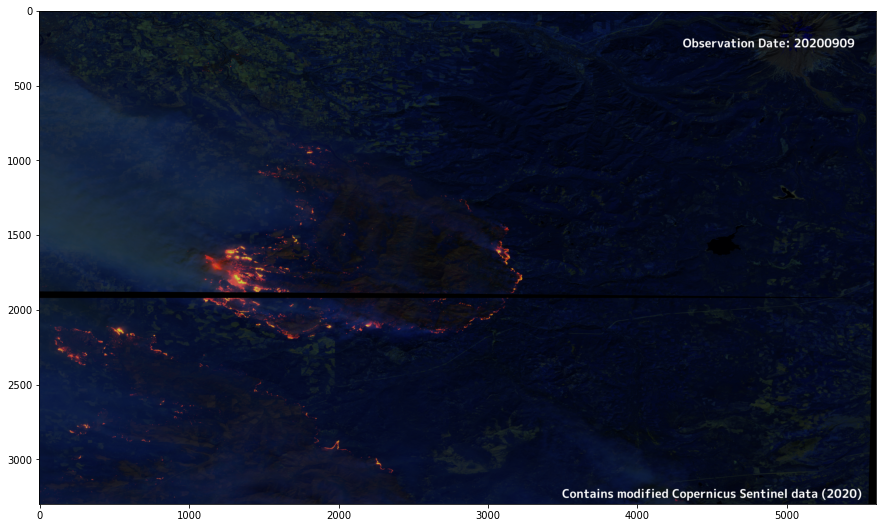

In [30]:
date = files[n][0:8]

img = Image.open(str(object_name) +'.jpg')

img = img.convert('RGB')

x = int(img.size[0]/1.3) #日付の記載位置の設定
y = int(img.size[1]/20) #日付の記載位置の設定
fs = int(img.size[0]/70) #日付のフォントサイズの設定

obj_draw = ImageDraw.Draw(img)
obj_font = ImageFont.truetype(fontfile, fs)
obj_draw.text((x, y), 'Observation Date: '+str(date), fill=(255, 255, 255), font=obj_font)
obj_draw.text((img.size[0]/1.6, img.size[1]-y*0.1 - img.size[1]/30 ), 'Contains modified Copernicus Sentinel data (2020)', fill=(255, 255, 255), font=obj_font)

img = img.resize((int(img.size[0] / 2) , int(img.size[1] / 2)))

#img = img.convert('L')


img.save(str(object_name) +'.jpg')

plt.figure(figsize=(15, 20))

plt.imshow(img)
plt.show()